

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Conditional Generative Adversarial Networks for Subsurface Modeling: How Good They Really Are?

#### Ahmed Merzoug, PhD Student, The University of Texas at Austin
#### [LinkedIn](https://www.linkedin.com/in/ahmed-merzoug/) | [GitHub](https://github.com/amerzoug) 

#### Michael Pyrcz, Associate Professor,The University of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)


#### Work completed as part of the DIRECT consortium for Subsurface Data Analytics and Machine Learning

#### Executive Summay
Generative adversarial networks (GANs) are increasingly recognized for their potential in subsurface modeling and uncertainty quantification, thanks to their capability to learn complex geological patterns from spatial training images and their ability to perform rapid local data conditioning in a lower-dimensional latent space compared to the full-dimensional space of the images. However, the performance of these algorithms often receives acceptance based primarily on visual inspection or limited qualitative assessment. To address this, we propose a minimum acceptance criteria workflow designed to quantitatively assess and verify the adequacy of GAN-generated subsurface models. This evaluation is carried out through three key metrics: (1) reproduction of data distribution, (2) reproduction of spatial continuity, and (3) local data conditioning. 

Our proposed workflow applied to GANs trained on a variety of images from sequential Gaussian simulations demonstrates that while data distribution and spatial continuity are consistently well-reproduced, local data conditioning faces several challenges. These include increasing prediction error and the need for more iterations for conditioning as the number of conditioning data increases. Additionally, the conditioning process at these data locations tends to introduce artifacts near the data locations including high local variogram nugget effects. Our minimum acceptance criteria offer a comprehensive framework for evaluating various models ensuring a higher control on modeling quality acceptance and rejection. 

We recommend applying this workflow before using generative artificial intelligence for subsurface modeling. This avoids the ocular-based approach and provides quantitative model assessment capabilities.


#### Import required libraries 

In [1]:
import torch  # Importing PyTorch, a popular deep learning framework
import torch.nn as nn  # Importing neural network modules from PyTorch
import torch.optim as optim  # Importing optimization algorithms from PyTorch
from torch.utils.data import Dataset, DataLoader  # Importing utilities for working with datasets and data loaders in PyTorch
from torchvision import datasets, transforms  # Importing torchvision datasets and transforms for image processing
import numpy as np  # Importing NumPy for numerical operations
from PIL import Image  # Importing Python Imaging Library (PIL) for image processing
import os  # Importing os module for operating system dependent functionality (like file manipulation)
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting and visualization
from scipy.optimize import minimize  # Importing optimization function from SciPy for minimizing a function
from scipy.spatial.distance import pdist, squareform  # Importing functions for pairwise distance calculation and square form conversion
from scipy.interpolate import interp1d  # Importing interpolation function from SciPy
import geostatspy.GSLIB as GSLIB  # Importing GSLIB utilities for geostatistical visualization and wrapper functions
import geostatspy.geostats as geostats  # Importing geostatistical functions like variogram calculations
from scipy import stats  # Importing statistical functions from SciPy
import imageio  # Importing imageio for reading and writing image data
from numba import jit  # Importing JIT (just-in-time) compiler from Numba for numerical speed up
from scipy.stats import linregress  # Importing linear regression function from SciPy
from scipy.integrate import quad  # Importing numerical integration function from SciPy
import statistics  # Importing statistics module for basic statistical functions
import pandas as pd  # Importing Pandas for data manipulation and analysis


#### Loading Generator 

In [2]:
# Define the generator network
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            # Linear layer to project and reshape the latent vector z
            nn.Linear(z_dim, 128 * 4 * 4),  # Matches corrected starting dimension
            nn.BatchNorm1d(128 * 4 * 4),  # Batch normalization
            nn.ReLU(True),  # Activation function
            nn.Unflatten(1, (128, 4, 4)),  # Reshape to (128, 4, 4)
            
            # First upsample to (16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Transpose convolution
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(True),  # Activation function
            
            # Second upsample to (32, 32)
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Transpose convolution
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(True),  # Activation function
            
            # Final layer to adjust output channels and normalize
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Transpose convolution
            nn.Tanh()  # Activation function to normalize between [-1, 1]
        )

    def forward(self, z):
        return self.net(z)

# Function to scale generated images back to the original range
def scale_to_original(generated_images, min_val, max_val, mean, std):
    # Reverse the normalization
    images = generated_images * std + mean
    # Scale back to original range
    images = images * (max_val - min_val) + min_val
    return images

# Class to scale images to the unit interval [0, 1]
class ScaleToUnitInterval(object):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, sample):
        return (sample - self.min_val) / (self.max_val - self.min_val)

# Custom Dataset for loading grayscale images from an npz file
class GrayscaleNPZDataset(Dataset):
    def __init__(self, npz_path, transform=None):
        data = np.load(npz_path)  # Load data from npz file
        self.images = data['my_array1']  # Extract images from the npz file
        self.scaler = ScaleToUnitInterval(np.min(self.images), np.max(self.images))  # Initialize scaler
        self.transform = transform  # Set transformation if any
    
    def __len__(self):
        return len(self.images)  # Return the number of images
    
    def __getitem__(self, idx):
        image = self.images[idx]  # Get the image at the specified index
        
        # Scale the image pixel values to [0, 1]
        image = self.scaler(image)
        
        # Convert to tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        # Add a channel dimension (PyTorch expects CxHxW)
        image = image.unsqueeze(0)
        
        # Apply additional transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image

# Assume generated_images is a batch of images from the generator
generator = Generator(z_dim=100)

# Load the state dictionary (assuming 'wgan_generator.pth' is the correct path)
state_dict = torch.load('C:/Users/am224745/Desktop/VAE GAN DDPM/GAN/50/checkpoints/generator_epoch_10000.pth', map_location='cpu')
generator.load_state_dict(state_dict)  # Load the generator's weights

# Set the model instance to evaluation mode
generator.eval()

# Generate images
num_images = 1  # Number of images to generate
z = torch.randn(num_images, 100)  # Random noise vector

# Function to generate images and scale them back to the original range
def generateimagefunction(z):
    # Generate images with no gradient computation
    with torch.no_grad():
        generated_images = generator(z).squeeze()
        
    # Define transformation to normalize generated images
    transform = transforms.Compose([
        transforms.Normalize((0.5,), (0.5,))  # This assumes the data is already scaled to [0, 1]
    ])
    
    # Load dataset for scaling purposes
    dataset = GrayscaleNPZDataset('C:/Users/am224745/Documents/Codes AM/SGS/my_data50_32_32.npz', transform=transform)
    
    min_val_original = np.min(dataset.images)  # Minimum value in the original dataset
    max_val_original = np.max(dataset.images)  # Maximum value in the original dataset
    mean = 0.5  # Mean used in transforms.Normalize
    std = 0.5   # Standard deviation used in transforms.Normalize
    
    # Scale the generated images back to the original range
    scaled_back_images = scale_to_original(generated_images, min_val_original, max_val_original, mean, std)
    scaled_back_images_np = scaled_back_images.cpu().detach().numpy()  # Convert to NumPy array
    return scaled_back_images_np

# Initialize an empty list to store errors
errors = []

# Objective function for optimization
def objective_function(z, target_locations, target_values, iteration=[0], optres=[0]):
    # Increment the iteration count
    iteration[0] += 1

    # Convert z to a PyTorch tensor
    z_tensor = torch.from_numpy(z).float().view(1, -1)

    # Generate the image using the provided function
    generated_image = generateimagefunction(z_tensor).squeeze()

    # Calculate the total and relative errors
    total_error = 0
    for loc, target in zip(target_locations, target_values):
        total_error += abs(generated_image[loc] - target)

    # Calculate the relative error normalized by the number of points
    relative_error = total_error / np.sum(np.abs(target_values)) 
    
    optres.fun = relative_error
    optres.genimage = generated_image
    optres.iteration = iteration[0]
    optres.zoptimum = z

    # Early stopping check
    if relative_error < 0.01:
        raise StopIteration(f"Early stopping criterion met at iteration {iteration[0]} - Total Error: {total_error:.2f}, Relative Error: {relative_error:.4f}")
    
    return relative_error


Define Indexes

In [ ]:
# Function to calculate the variogram of a given dataset
def calculate_variogram(data, dx, dy, nlag):
    lag_distance, vario, npairs = geostats.gam(
        data, tmin=-9999, tmax=9999, xsiz=10, ysiz=10,
        ixd=2, iyd=0, nlag=31, isill=1.0
    )
    return lag_distance, vario, npairs

# Function to calculate overlap area between histograms of two images
def overlaparea(combined_new_tensor, generated_image):
    hist1, bins = np.histogram(combined_new_tensor.squeeze()[np.random.randint(0, 100), :, :].flatten(), bins=50, range=(min(combined_new_tensor.squeeze()[1, :, :].flatten()), max(combined_new_tensor.squeeze()[np.random.randint(0, 100), :, :].flatten())), density=True)
    hist2, _ = np.histogram(generated_image.flatten(), bins=bins, density=True)
    overlap = np.sum(np.minimum(hist1, hist2) * np.diff(bins))
    return overlap


# Function to calculate overlap area between histograms of two images
def overlaparea(combined_new_tensor, generated_image):
    hist1, bins = np.histogram(combined_new_tensor.squeeze()[np.random.randint(0, 100), :, :].flatten(), bins=50, range=(min(combined_new_tensor.squeeze()[1, :, :].flatten()), max(combined_new_tensor.squeeze()[np.random.randint(0, 100), :, :].flatten())), density=True)
    hist2, _ = np.histogram(generated_image.flatten(), bins=bins, density=True)
    overlap = np.sum(np.minimum(hist1, hist2) * np.diff(bins))
    return overlap


# Function to normalize data to [0, 1] range
def min_max_normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


# Function to calculate total absolute area between two samples
def calculate_total_absolute_area(sample1, sample2):
    sample1_normalized = min_max_normalize(sample1)
    sample2_normalized = min_max_normalize(sample2)
    quantiles1 = np.percentile(sample1_normalized, np.linspace(0, 100, 100))
    quantiles2 = np.percentile(sample2_normalized, np.linspace(0, 100, 100))

    slopes = []
    intercepts = []
    for i in range(len(quantiles1) - 1):
        slope, intercept, _, _, _ = linregress([quantiles1[i], quantiles1[i+1]], [quantiles2[i], quantiles2[i+1]])
        slopes.append(slope)
        intercepts.append(intercept)

    def segment_linear_fit(x, index):
        return slopes[index] * x + intercepts[index]

    def calculate_absolute_area_under_segment(index):
        area = quad(lambda x: abs(segment_linear_fit(x, index) - x), quantiles1[index], quantiles1[index+1])[0]
        return area

    total_absolute_area = sum(calculate_absolute_area_under_segment(i) for i in range(len(slopes)))
    return total_absolute_area

# Function to calculate the average variance around specified points in an image
def calculate_average_variance_around_points(generated_image, target_locations):
    variances = []
    for (x, y) in target_locations:
        neighboring_values = [generated_image[x, y]]  # Include the value at (x, y)
        if x > 0:
            neighboring_values.append(generated_image[x-1, y])
        if x < generated_image.shape[0] - 1:
            neighboring_values.append(generated_image[x+1, y])
        if y > 0:
            neighboring_values.append(generated_image[x, y-1])
        if y < generated_image.shape[1] - 1:
            neighboring_values.append(generated_image[x, y+1])
        
        if neighboring_values:
            variances.append(np.var(neighboring_values))

    return np.mean(variances) if variances else 0

# Function to calculate variance for all pixels in an image
def calculate_variance_for_all_pixels(image):
    variance_map = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            neighboring_values = [image[x, y]]  # Include the value at (x, y)
            if x > 0:
                neighboring_values.append(image[x-1, y])
            if x < image.shape[0] - 1:
                neighboring_values.append(image[x+1, y])
            if y > 0:
                neighboring_values.append(image[x, y-1])
            if y < image.shape[1] - 1:
                neighboring_values.append(image[x, y+1])

            variance_map[x, y] = np.var(neighboring_values)
    return variance_map.mean()

# Function to calculate variance away from conditioned points in an image
def calculate_neighbor_variance_away_from_conditioned(generated_image, conditioned_points, lag):
    variances = []

    for x in range(generated_image.shape[0]):
        for y in range(generated_image.shape[1]):
            if all(np.sqrt((x - cx)**2 + (y - cy)**2) > lag for cx, cy in conditioned_points):
                neighboring_values = [generated_image[x, y]]  # Include the value at (x, y)
                if x > 0:
                    neighboring_values.append(generated_image[x-1, y])
                if x < generated_image.shape[0] - 1:
                    neighboring_values.append(generated_image[x+1, y])
                if y > 0:
                    neighboring_values.append(generated_image[x, y-1])
                if y < generated_image.shape[1] - 1:
                    neighboring_values.append(generated_image[x, y+1])

                if neighboring_values:
                    variances.append(np.var(neighboring_values))

    return np.mean(variances) if variances else 0

# Function to calculate indices for specified locations in an image
def indexingfunction(z, locations):
    flattened_indices = []

    for location in locations:
        x, y = location
        if x < 2 or y < 2 or x > 127 or y > 127:
            continue  # Skip this location

        indexx = []
        indexy = []
        II = 1
        IY = 1

        for s in np.arange(4):
            if z[x-2+s, y] < z[x-1+s, y]:
                indexx.append(1)
            else:
                indexx.append(0)

        for j in np.arange(4):
            II += indexx[j] * 2 ** j

        for s in np.arange(4):
            if z[x, y-2+s] < z[x, y-1+s]:
                indexy.append(1)
            else:
                indexy.append(0)

        for j in np.arange(4):
            IY += indexy[j] * 2 ** j

        flattened_indices.extend([II, IY])

    return flattened_indices

# Function to generate non-conditioned realizations



### Pattern-Based Approach to Investigate Artifacts in Realizations Near Conditioning Data

To investigate the existence of artifacts in realizations near conditioning data, specifically data conditioning as local minima or maxima, we analyze five consecutive points near the conditioned data $z(u)$. The following locations are used: $z(u-2)$, $z(u-1)$, $z(u)$, $z(u+1)$, and $z(u+2)$. 

The near data patterns are quantified using an indicator transform:

$$
i_k = 
\begin{cases} 
1, & \text{if } z(u+k) \leq z(u+k-1) \\
0, & \text{otherwise}
\end{cases}

$$


The indicators are summarized as an index that varies from 1 to 16. Figure 7 illustrates the different indexes and their corresponding patterns. If the distribution of the indexes is uniform, there are no local minima or maxima conditioning artifacts. The index is calculated as follows:

$$
\text{Index} = 1 + \sum_{j=1}^{4} i_j \cdot 2^{(j-1)} 
$$


where $i$ is the list of the four indicators $i_k$ and $j$ is the indicator identifier $\{1, 2, 3, 4\}$.




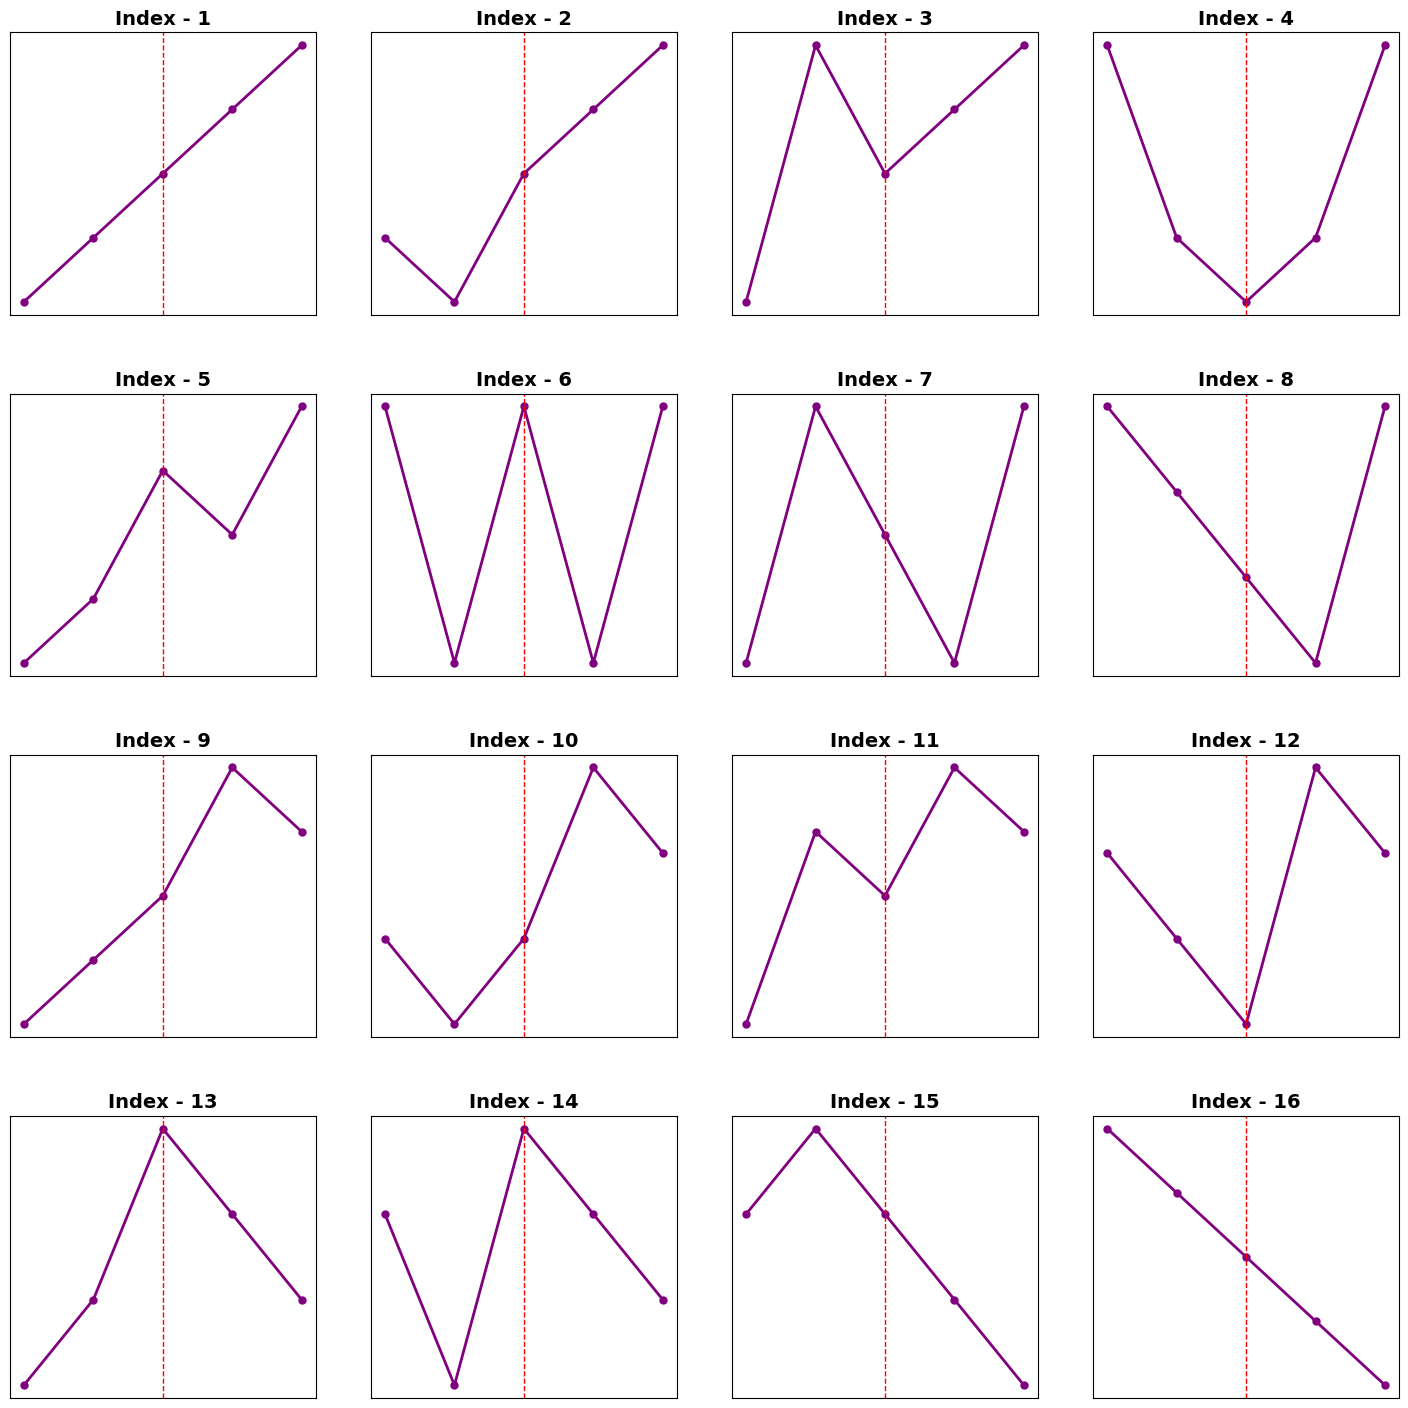

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# Simulated data from the user's message structured as a CSV string for demonstration purposes
data = """
1,2,3,4,5
2,1,3,4,5
1,5,3,4,5
5,2,1,2,5
1,2,4,3,5
5,4,5,4,5
1,5,3,1,5
5,4,3,2,5
1,2,3,5,4
3,2,3,5,4
1,4,3,5,4
4,3,2,5,4
1,2,4,3,2
3,1,4,3,2
3,4,3,2,1
5,4,3,2,1
"""

# Read the data into a DataFrame
df = pd.read_csv(StringIO(data), header=None)

# Improved plot setup
fig, axs = plt.subplots(4, 4, figsize=(15, 15), dpi=100, facecolor='w', edgecolor='k')

# Flatten the axis array for easy iteration and indexing
axs = axs.flatten()

# Plot each line in a separate subplot with the specified improvements
# Plot each line in a separate subplot with the specified improvements
for index, row in df.iterrows():
    # Plot with purple color and remove both x-axis and y-axis ticks and labels
    axs[index].plot(row, marker='o', linestyle='-', linewidth=2, markersize=5, color='purple')
    axs[index].set_title(f'Index - {index + 1}', fontsize=14, fontweight='bold')
    axs[index].tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    axs[index].axvline(x=2, color='red', linestyle='--', linewidth=1)
    axs[index].grid(False)  # Remove grid
# Adjust layout to prevent overlap
plt.tight_layout(pad=4.0)

# Show plot
plt.show()



#### Functions Section
Functions used during the worflow to calculate and plot results from classical DTW algorithm and physics constrain DTW

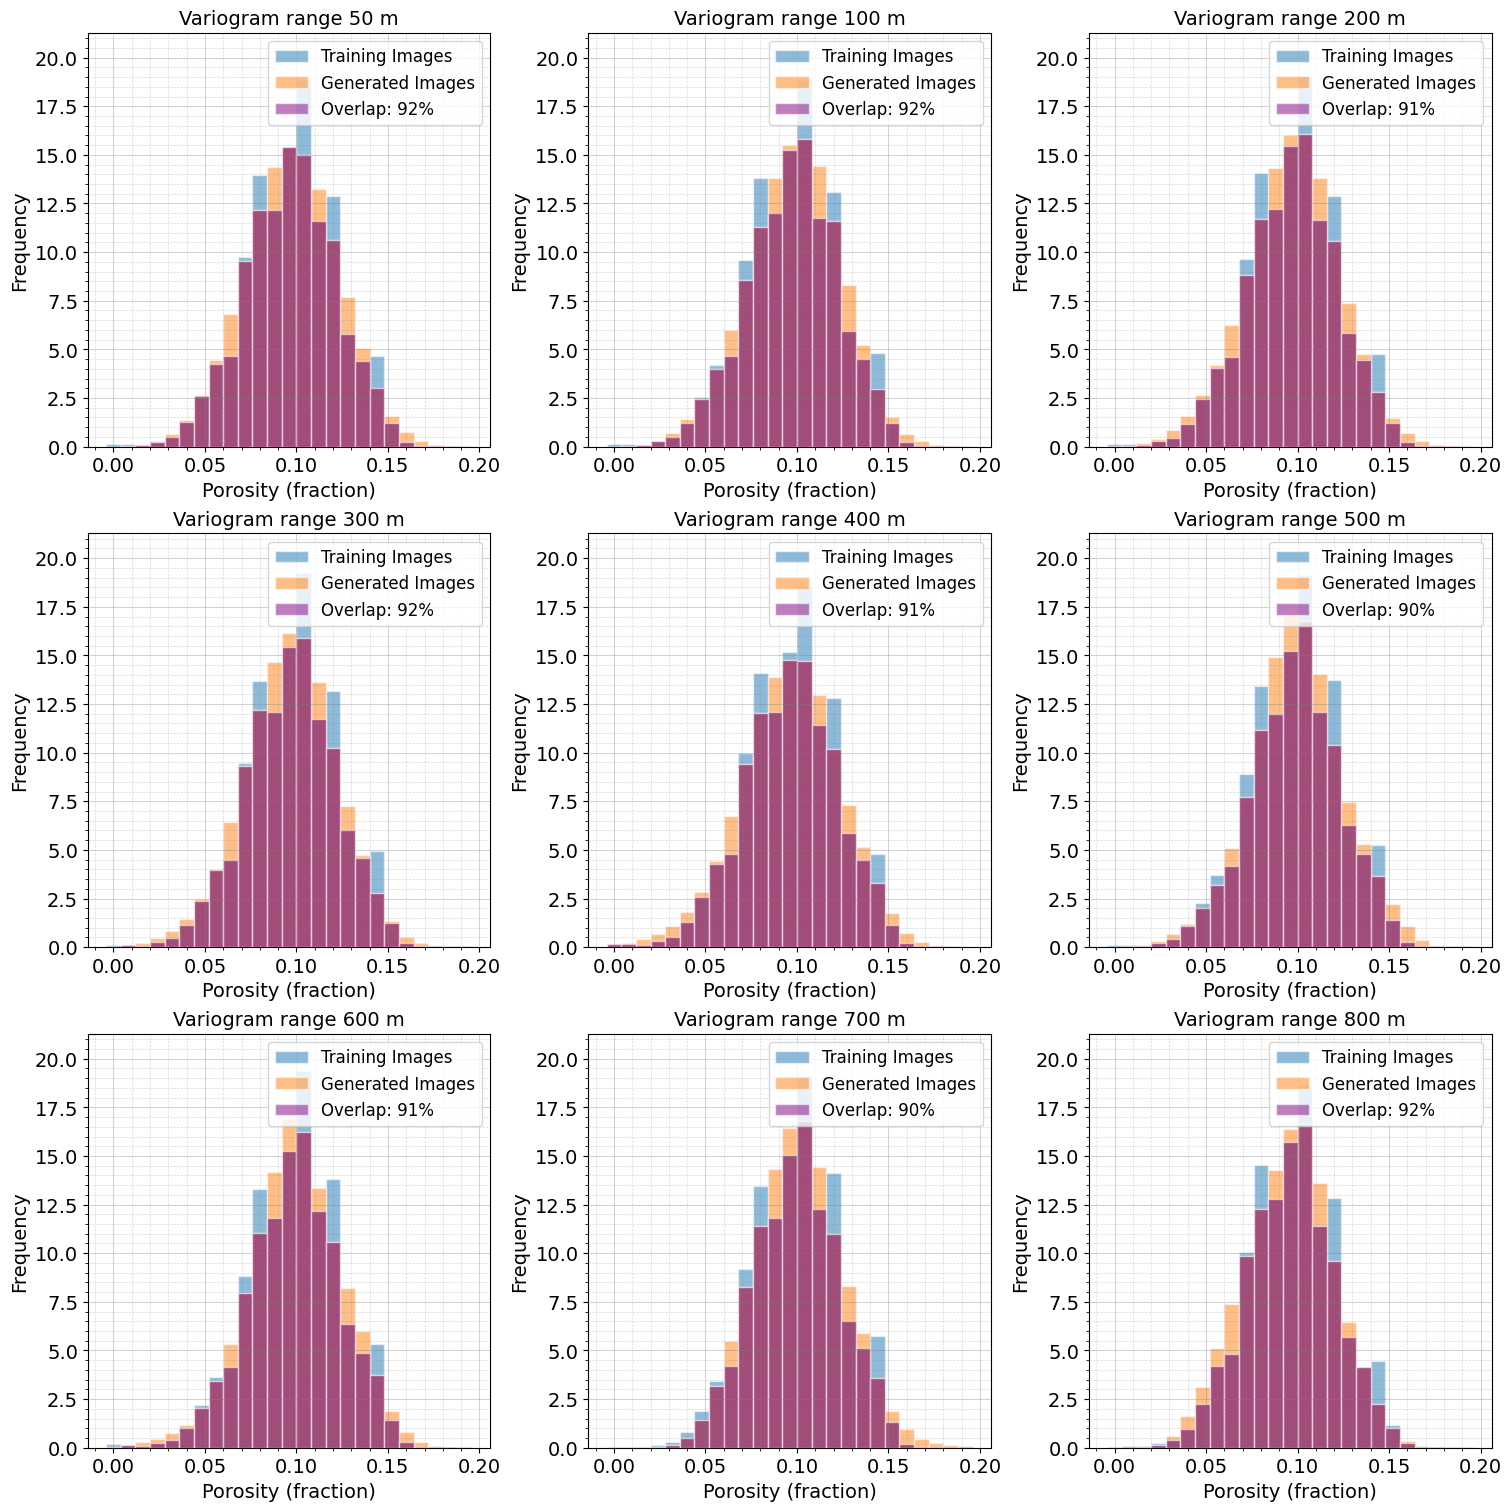

In [6]:
import numpy as np
import matplotlib.pyplot as plt


# Define the epochs to loop over
epochs = [50, 100, 200, 300, 400, 500, 600, 700, 800]

# Histogram range and bins
hist_range = (0, 0.2)  # Adjust this range based on your data's values
bins = 25

# Set up the plot for a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
axs = axs.ravel()

# Initialize a variable to track the maximum y-value
max_y_val = 0

for i, epoch in enumerate(epochs):
    new_data_path = f'C:/Users/am224745/Documents/Codes AM/SGS/my_data{epoch}.npz'
    new_data = np.load(new_data_path)
    new_images = [new_data[key] for key in new_data]
    combined_new_tensor = np.stack(new_images).squeeze()
    data1 = combined_new_tensor.reshape(combined_new_tensor.shape[0], -1).flatten()
    epoch_data_path = f'C:/Users/am224745/Documents/Codes AM/SGS/Gaussian/{epoch}/epoch_8000.npz'
    epoch_data = np.load(epoch_data_path)
    epoch_images = [epoch_data[key] for key in epoch_data]
    combined_epoch_tensor = np.stack(epoch_images).squeeze()
    data2 = combined_epoch_tensor.reshape(combined_epoch_tensor.shape[0], -1).flatten()

    # Create normalized histograms for both distributions
    hist1, bins = np.histogram(data1, bins=bins, range=hist_range, density=True)
    hist2, _ = np.histogram(data2, bins=bins, range=hist_range, density=True)
    bin_width = np.diff(bins)

    # Calculate the overlapping area
    overlap = np.sum(np.minimum(hist1, hist2) * bin_width)
    total_area_new_data = np.sum(hist1 * bin_width)
    overlap_percentage = (overlap / total_area_new_data) * 100

    # Plot both histograms and the overlapping area in the subplot
    axs[i].bar(bins[:-1], hist1, width=bin_width, alpha=0.5, edgecolor='white', label='Training Images')
    axs[i].bar(bins[:-1], hist2, width=bin_width, alpha=0.5, edgecolor='white', label=f'Generated Images')
    overlap_area = np.minimum(hist1, hist2)
    axs[i].bar(bins[:-1], overlap_area, width=bin_width, color='purple', edgecolor='white', alpha=0.5)

    # Set titles and labels for the subplot
    axs[i].set_title(f'Variogram range {epoch} m', fontsize = 14)
    axs[i].set_xlabel('Porosity (fraction)', fontsize = 14)
    axs[i].set_ylabel('Frequency', fontsize = 14)

    # Update max_y_val if necessary
    max_y_val = max(max_y_val, max(hist1.max(), hist2.max()))

    # Adding overlap percentage to the legend
    overlap_label = f'Overlap: {overlap_percentage:.0f}%'
    handles, labels = axs[i].get_legend_handles_labels()
    handles.append(plt.Rectangle((0, 0), 1, 1, fc="purple", edgecolor='white', alpha=0.5))  # Create a custom legend handle
    labels.append(overlap_label)
    axs[i].legend(handles, labels, fontsize = 12)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    axs[i].grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    axs[i].minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    axs[i].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)



# Set the same y-axis limit for all subplots after determining the maximum y-value
for ax in axs:
    ax.set_ylim(0, max_y_val * 1.1)  # Slightly above the max value for visual clarity

plt.show()


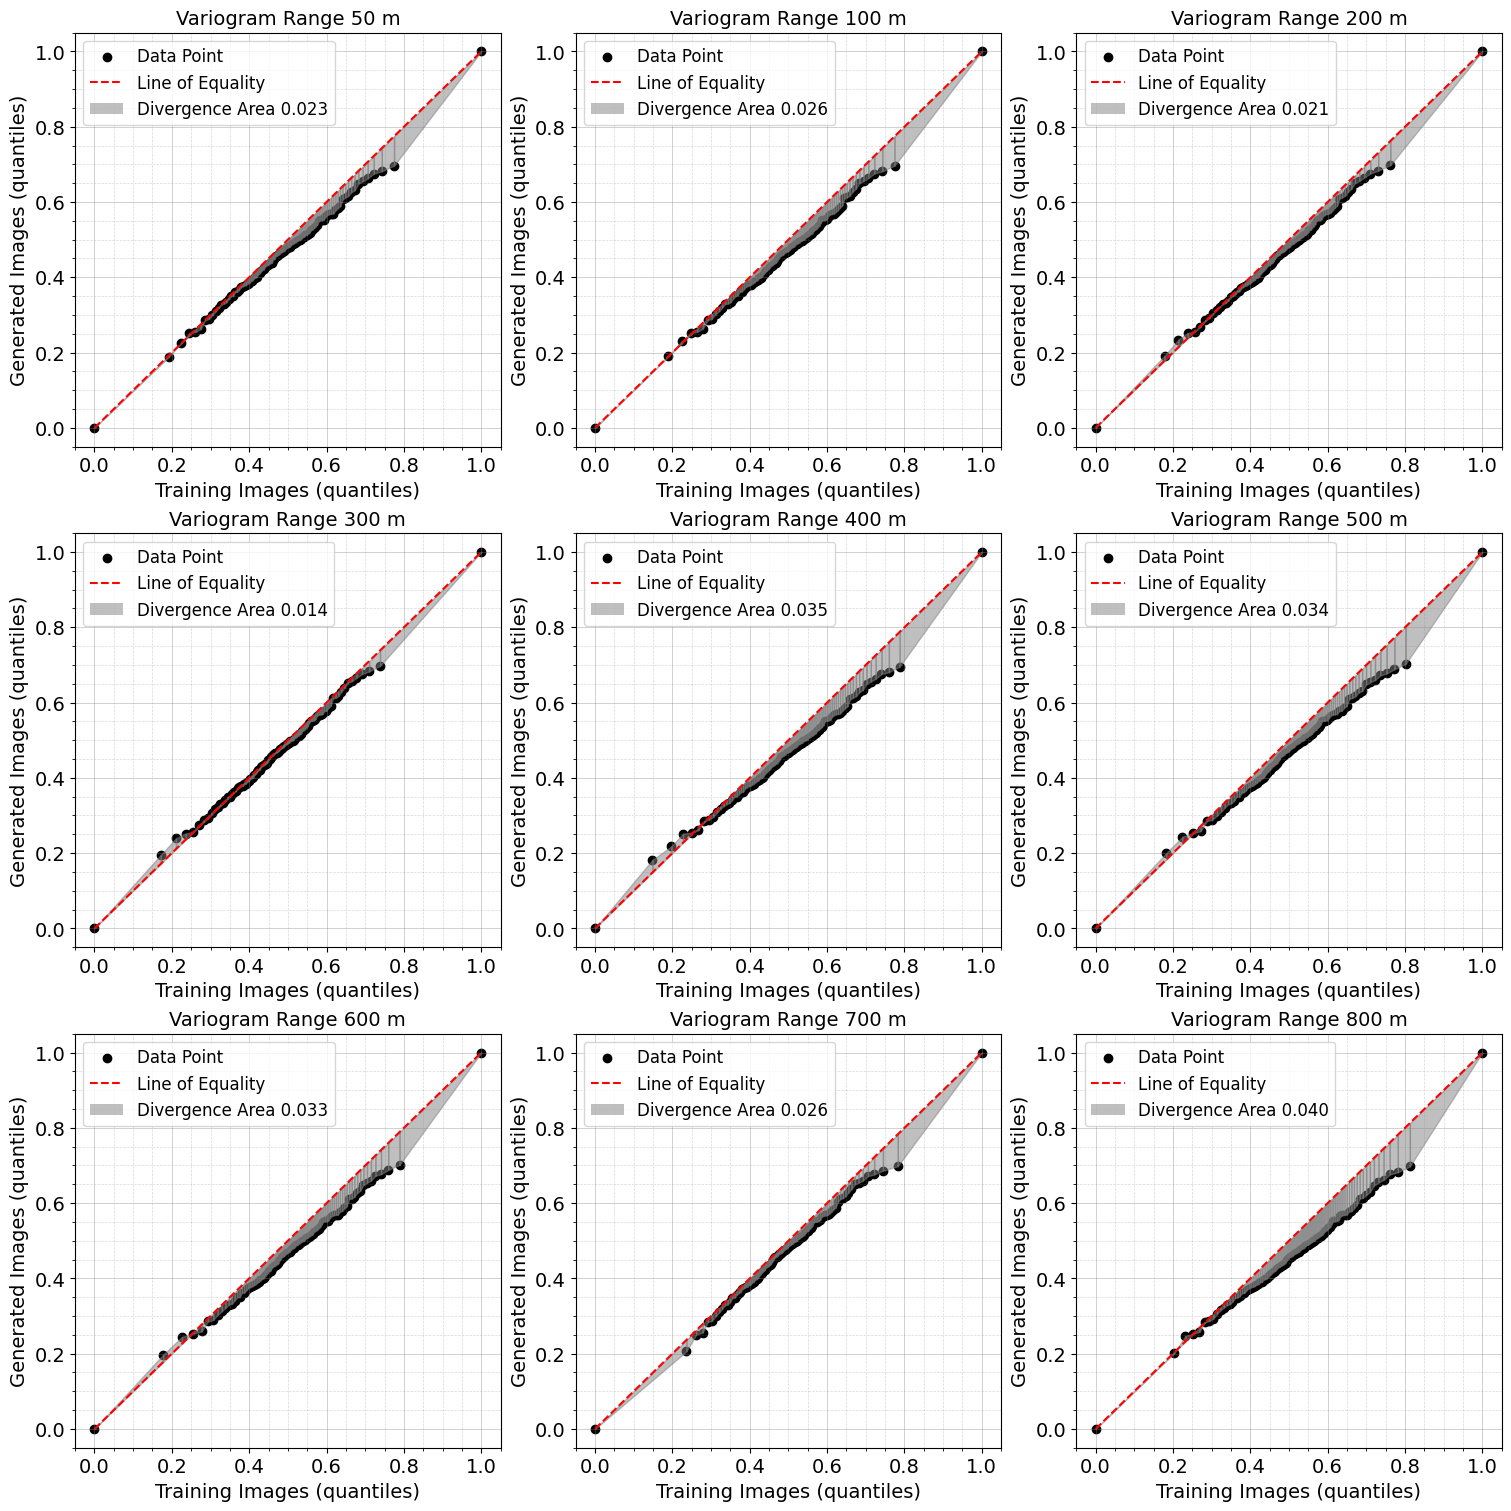

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.integrate import quad

# Define the epochs to loop over
epochs = [50, 100, 200, 300, 400, 500, 600, 700, 800]

# Set up the plot for a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
axs = axs.ravel()

def calculate_slopes_intercepts(quantiles1, quantiles2):
    slopes = []
    intercepts = []
    for i in range(len(quantiles1) - 1):
        slope, intercept, _, _, _ = linregress([quantiles1[i], quantiles1[i+1]], [quantiles2[i], quantiles2[i+1]])
        slopes.append(slope)
        intercepts.append(intercept)
    return slopes, intercepts

def segment_linear_fit(x, index, slopes, intercepts):
    return slopes[index] * x + intercepts[index]

def calculate_absolute_area_under_segment(index, quantiles1, slopes, intercepts):
    area = quad(lambda x: abs(segment_linear_fit(x, index, slopes, intercepts) - x), quantiles1[index], quantiles1[index+1])[0]
    return area

def load_and_prepare_data(epoch):
    data = np.load(f'C:/Users/am224745/Documents/Codes AM/SGS/Gaussian/{epoch}/epoch_8000.npz')
    images = [data[key] for key in data]
    combined_tensor = np.stack(images).squeeze()

    new_data = np.load(f'C:/Users/am224745/Documents/Codes AM/SGS/my_data{epoch}.npz')
    new_images = [new_data[key] for key in new_data]
    combined_new_tensor = np.stack(new_images).squeeze()

    def min_max_normalize(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    sample1 = min_max_normalize(combined_tensor.reshape(-1))
    sample2 = min_max_normalize(combined_new_tensor.reshape(-1))
    quantiles1 = np.percentile(sample1, np.linspace(0, 100, 100))
    quantiles2 = np.percentile(sample2, np.linspace(0, 100, 100))
    return quantiles1, quantiles2

for i, epoch in enumerate(epochs):
    quantiles1, quantiles2 = load_and_prepare_data(epoch)
    slopes, intercepts = calculate_slopes_intercepts(quantiles1, quantiles2)
    total_absolute_area = sum(calculate_absolute_area_under_segment(i, quantiles1, slopes, intercepts) for i in range(len(slopes)))

    axs[i].scatter(quantiles1, quantiles2, color='black', label='Data Point')
    min_quantile, max_quantile = min(quantiles1), max(quantiles2)
    axs[i].plot([min_quantile, max_quantile], [min_quantile, max_quantile], 'r--', label='Line of Equality')

    # Shading the area that is further from the 45-degree line
    for j in range(len(slopes)):
        x_segment = np.linspace(quantiles1[j], quantiles1[j+1], 100)
        y_segment_fit = segment_linear_fit(x_segment, j, slopes, intercepts)
        axs[i].fill_between(x_segment, x_segment, y_segment_fit, where=(y_segment_fit > x_segment), color='grey', alpha=0.5, interpolate=True)
        axs[i].fill_between(x_segment, y_segment_fit, x_segment, where=(y_segment_fit < x_segment), color='grey', alpha=0.5, interpolate=True)

    axs[i].set_title(f'Variogram Range {epoch} m', fontsize = 14)
    axs[i].set_xlabel('Training Images (quantiles)', fontsize = 14)
    axs[i].set_ylabel('Generated Images (quantiles)', fontsize = 14)
    divergence_label = f'Divergence Area {total_absolute_area:.3f}'
    total_area_label = f'Total Absolute Area: {total_absolute_area:.3f}'
    handles, labels = axs[i].get_legend_handles_labels()
    handles.append(plt.Rectangle((0,0),1,1,fc='grey', edgecolor='none', alpha=0.5))  # Add custom handle for divergence area
    labels.append(divergence_label)
    labels.append(total_area_label)
    axs[i].legend(handles, labels, loc='upper left',fontsize = 12)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    axs[i].minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    axs[i].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

plt.show()


c:\ProgramData\Anaconda3\envs\Torch\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\Torch\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\Torch\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\Torch\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppres

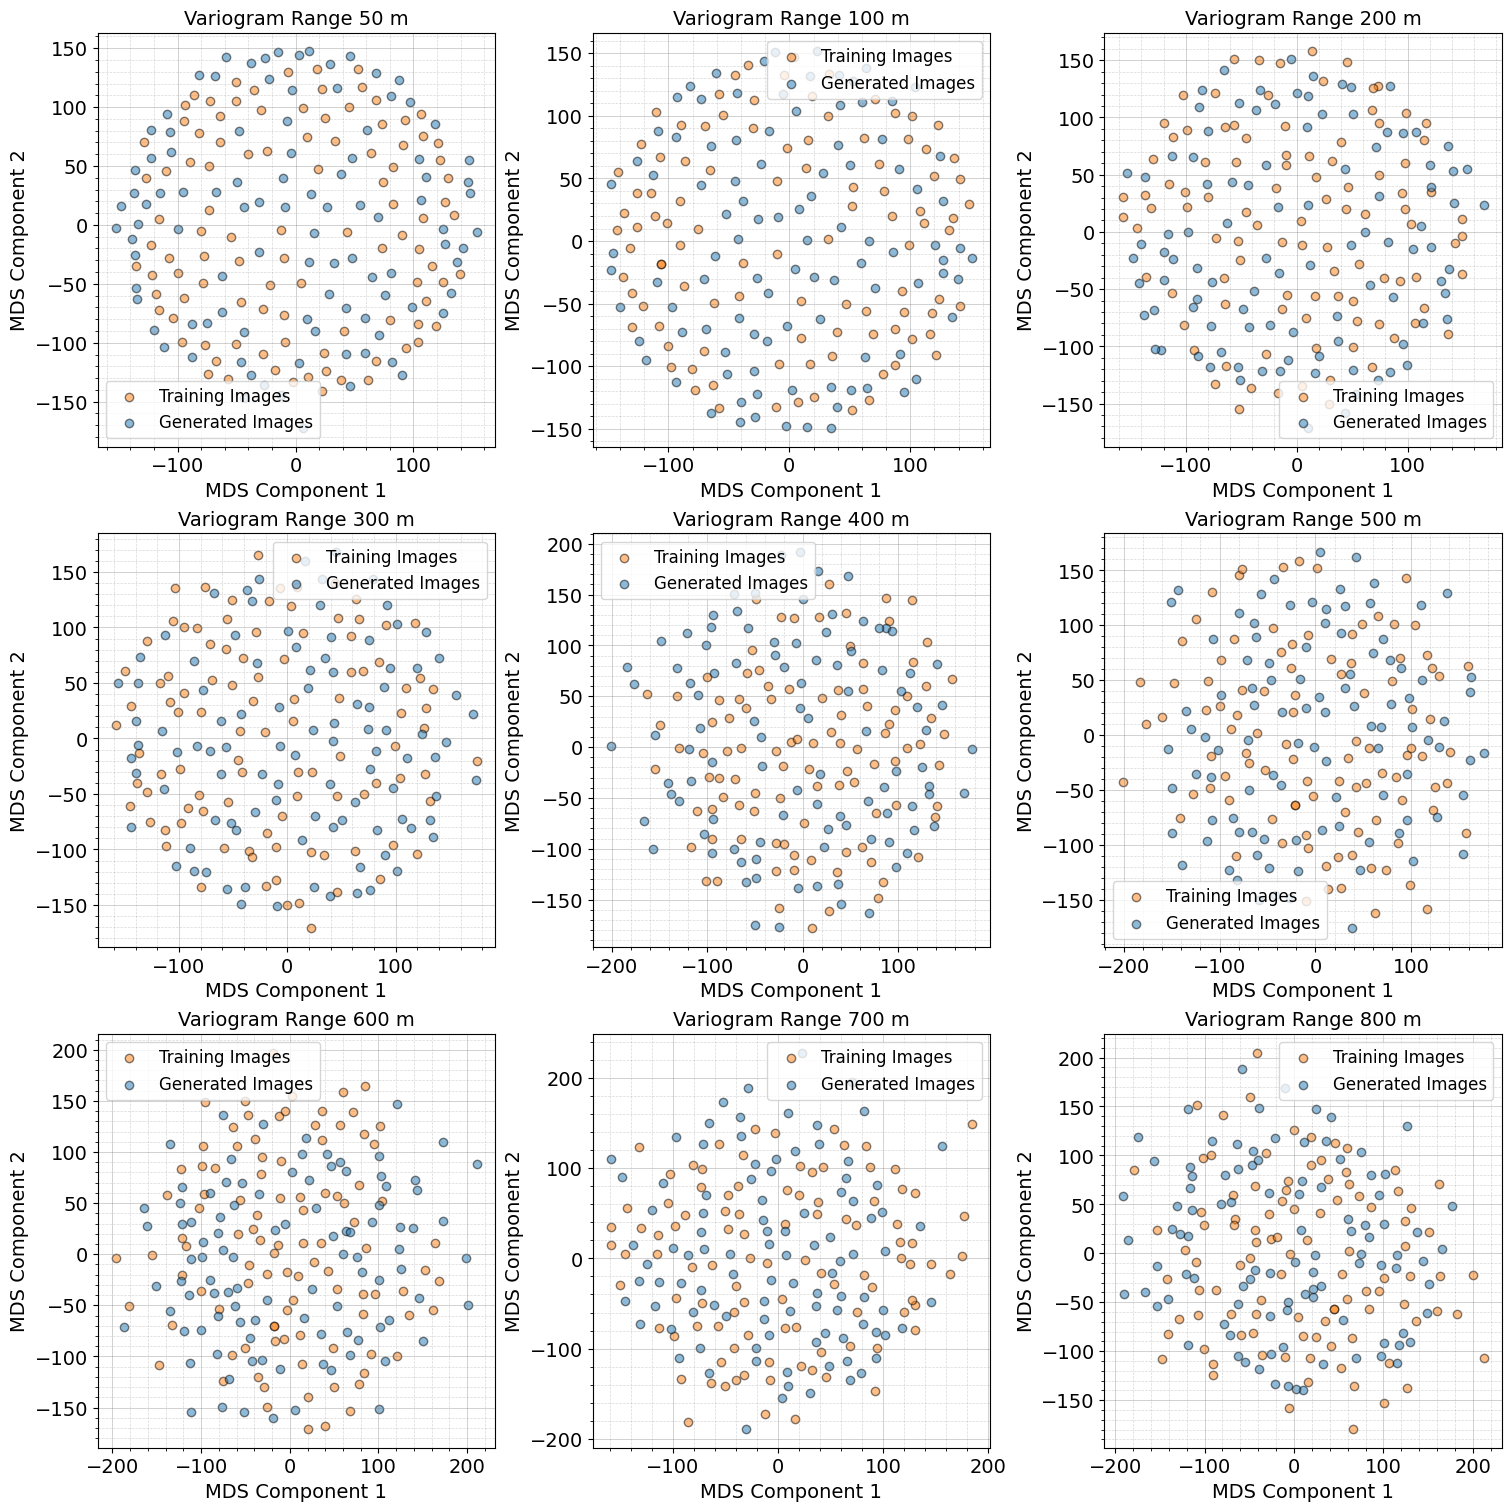

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# Load the constant new data
new_data = np.load('C:/Users/am224745/Documents/Codes AM/SGS/my_data300.npz')
new_images = [new_data[key] for key in new_data]
combined_new_tensor = np.stack(new_images).squeeze()
new_data_flat = combined_new_tensor.reshape(combined_new_tensor.shape[0], -1)

# Initialize the scaler and standardize the new data
scaler = StandardScaler()
new_data_flat = scaler.fit_transform(new_data_flat)

# Select the epochs for the 3x3 grid
epochs = [50, 100, 200, 300, 400, 500, 600, 700, 800]

# Set up the plot for a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)
axs = axs.ravel()  # Flatten the axis for easy iteration

for i, epoch in enumerate(epochs):

    # Load the constant new data
    new_data = np.load(f'C:/Users/am224745/Documents/Codes AM/SGS/my_data{epoch}.npz')
    new_images = [new_data[key] for key in new_data]
    combined_new_tensor = np.stack(new_images).squeeze()
    new_data_flat = combined_new_tensor.reshape(combined_new_tensor.shape[0], -1)

    # Initialize the scaler and standardize the new data
    scaler = StandardScaler()
    new_data_flat = scaler.fit_transform(new_data_flat)
    file_path = f'C:/Users/am224745/Documents/Codes AM/SGS/Gaussian/{epoch}/epoch_8000.npz'
    
    data = np.load(file_path)
    images = [data[key] for key in data]
    combined_tensor = np.stack(images).squeeze()
    data_flat = combined_tensor.reshape(combined_tensor.shape[0], -1)
    
    # Standardize the epoch data using the same scaler as the new data
    data_flat = scaler.transform(data_flat)
    
    # Combine the new data and epoch data
    combined_data = np.vstack((new_data_flat, data_flat))
    
    # Compute the dissimilarity (distance) matrix using Euclidean distances
    dissimilarity_matrix = pairwise_distances(combined_data, metric='euclidean')
    
    # Perform MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', metric=True, random_state=42)
    mds_transformed_data = mds.fit_transform(dissimilarity_matrix)
    
    # Plotting
    axs[i].scatter(mds_transformed_data[:new_data_flat.shape[0], 0], mds_transformed_data[:new_data_flat.shape[0], 1], c='C1', label='Training Images',alpha=0.5, edgecolors='k')
    axs[i].scatter(mds_transformed_data[new_data_flat.shape[0]:, 0], mds_transformed_data[new_data_flat.shape[0]:, 1], c='C0', label='Generated Images',alpha=0.5, edgecolors='k')
    
    axs[i].set_title(f'Variogram Range {epoch} m', fontsize = 14)
    axs[i].set_xlabel('MDS Component 1',fontsize = 14)
    axs[i].set_ylabel('MDS Component 2',fontsize = 14)
    axs[i].legend(fontsize = 12)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    axs[i].minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    axs[i].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

plt.show()


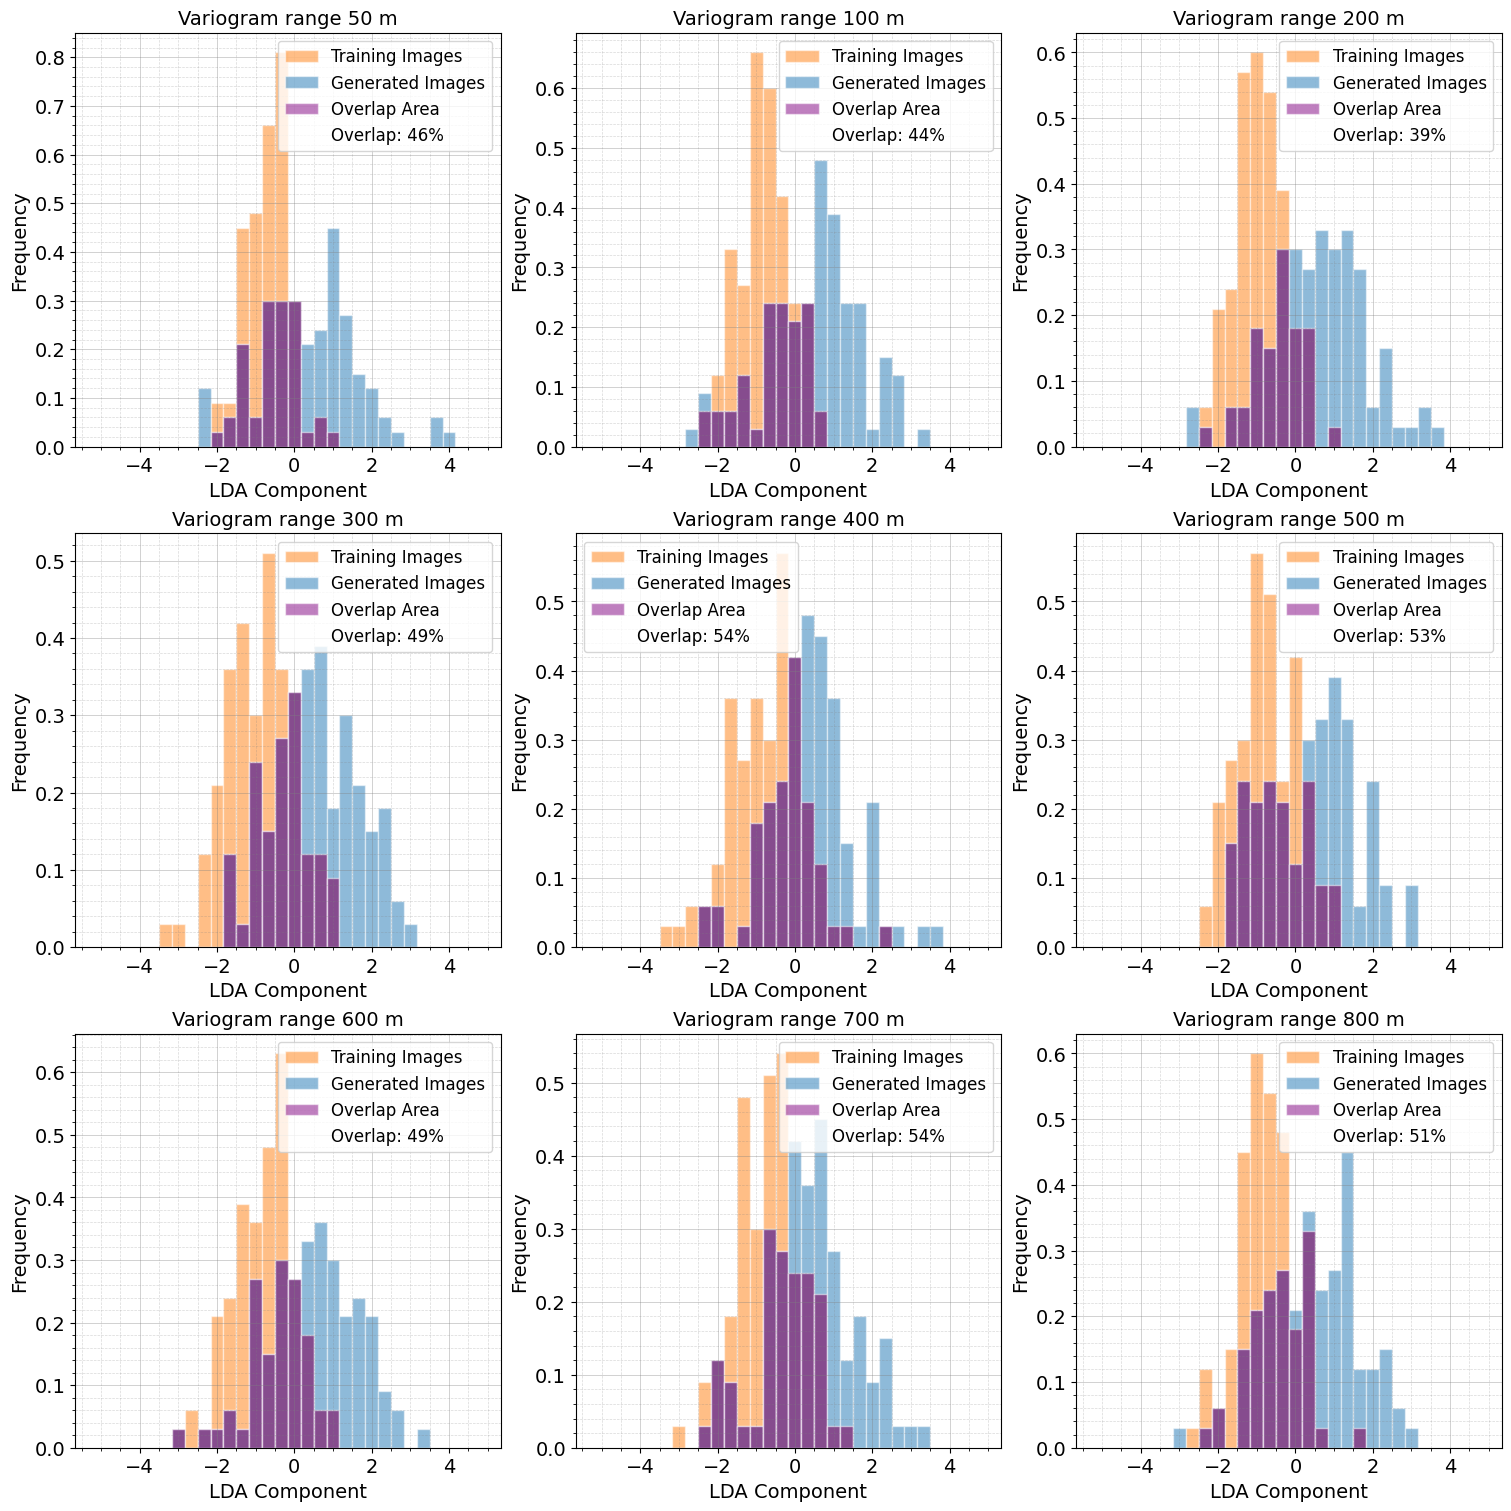

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt



# Select the epochs for the 3x3 grid
epochs = [50, 100, 200, 300, 400, 500, 600, 700, 800]

# Determine consistent bins across all histograms
bins = np.linspace(-5, 5, 31)

# Set up the plot for a 3x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)

for i, epoch in enumerate(epochs):
    row = i // 3
    col = i % 3

        # Load the constant new data
    new_data = np.load(f'C:/Users/am224745/Documents/Codes AM/SGS/my_data{epoch}.npz')
    new_images = [new_data[key] for key in new_data]
    combined_new_tensor = np.stack(new_images).squeeze()
    new_data_flat = combined_new_tensor.reshape(combined_new_tensor.shape[0], -1)

    # Initialize the scaler and standardize the new data
    scaler = StandardScaler()
    new_data_flat = scaler.fit_transform(new_data_flat)

    
    file_path = f'C:/Users/am224745/Documents/Codes AM/SGS/Gaussian/{epoch}/epoch_8000.npz'
    
    data = np.load(file_path)
    images = [data[key] for key in data]
    combined_tensor = np.stack(images).squeeze()
    data_flat = combined_tensor.reshape(combined_tensor.shape[0], -1)
    
    data_flat = scaler.transform(data_flat)
    
    labels = np.hstack((np.zeros(data_flat.shape[0]), np.ones(new_data_flat.shape[0])))
    
    lda = LDA(n_components=1)
    lda.fit(np.vstack(( new_data_flat,data_flat)), labels)
    
    data_lda = lda.transform(data_flat)
    new_data_lda = lda.transform(new_data_flat)
    
    # Calculate the overlapping area
    hist1, bin_edges = np.histogram(data_lda, bins=bins, density=True)
    hist2, _ = np.histogram(new_data_lda, bins=bins, density=True)
    overlap = np.sum(np.minimum(hist1, hist2) * np.diff(bins))
    bin_width = np.diff(bins)
    # Normalize the overlap by the new data area
    new_data_area = np.sum(hist2 * np.diff(bins))
    normalized_overlap = overlap / new_data_area
    
    for b in range(len(bins)-1):
        axs[row, col].bar(bins[b], hist2[b], width=bin_width[b], color='C1', edgecolor='white', alpha=0.5, label='Training Images' if b == 0 else "")
        axs[row, col].bar(bins[b], hist1[b], width=bin_width[b], color='C0', edgecolor='white', alpha=0.5, label='Generated Images' if b == 0 else "")
        
        
        # Determine and color the overlapping area in purple
        overlap_height = min(hist1[b], hist2[b])
        axs[row, col].bar(bins[b], overlap_height, width=bin_width[b], color='purple', edgecolor='white', alpha=0.5, label='Overlap Area' if b == 0 else "")

    
    # Set titles and labels
    axs[row, col].set_title(f'Variogram range {epoch} m', fontsize = 14)
    axs[row, col].set_xlabel('LDA Component',fontsize = 14)
    axs[row, col].set_ylabel('Frequency', fontsize = 14)
    axs[row, col].tick_params(axis='both', which='major', labelsize=14)
    
    # Calculate and display normalized overlap (you might want to adjust this calculation for your needs)
    overlap = np.sum(np.minimum(hist1, hist2) * np.diff(bins))
    new_data_area = np.sum(hist2 * np.diff(bins))
    normalized_overlap = overlap / new_data_area*100
    overlap_label = f'Overlap: {normalized_overlap:.0f}%'
    
    # Update the legend with overlap information
    handles, labels = axs[row, col].get_legend_handles_labels()
    handles.append(plt.Line2D([], [], color='none', label=overlap_label))
    axs[row, col].legend(handles=handles,fontsize = 12)
    axs[row, col].grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Enable the minor ticks
    axs[row, col].minorticks_on()

    # Modify the existing major grid settings if needed, or keep it as is
    axs[row, col].grid(True, which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

plt.show()
